<h1><center>Detecção de fraudes de cartão de crédito</center></h1>

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from warnings import filterwarnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, average_precision_score
from lightgbm import LGBMClassifier
from skopt import forest_minimize

filterwarnings('ignore')

<a name='IND'></a>
<h2>Indice</h2>
<font size=3>
<ol>
    <li><a href='#LOAD'>Carregando os dados</a></li> 
    <li><a href='#UNDRS'>Entendendo o dataset</a></li>
    <li><a href='#PREPRO'>Pré-processamento dos dados</a></li>
    <li><a href='#RF'>Random Forrest</a></li>
    <li><a href='#LGBM'>LightGBM</a></li>
    <li><a href='#BAYES'>Bayesian Optimization</a></li>
    <li><a href='#MODEL'>Modelo final</a></li>
</ol>    
</font>
    
<a name='LOAD'></a>
<h2>Carregando os dados</h2>
<font size=3>Vamos carregar os dados que foram disponibilizados no <a href='https://www.kaggle.com/mlg-ulb/creditcardfraud'>Kaggle</a>, e temos as seguintes informações sobre as variáveis:</font>
<ul>
    <li><b>Time:</b> diferença de tempo em segundos entre a transação e a primeira transação</li>
    <li><b>V1 ... V28:</b> são os componentes principais do PCA.</li>
    <li><b>Amount:</b> valor da transação.</li>
    <li><b>Class:</b> diz se a transação é fraudulenta (1) ou não (0).</li>
</ul>

In [3]:
df = pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


<a name='UNDRS'></a>
<h2>Entendendo o dataset</h2>

In [4]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,...,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


<font size=3>Como podemos ver temos um dataset desbalanceado, sendo apenas 0,17% dos registros como fraudes.</font>

In [5]:
df['Class'].value_counts()*100/df.shape[0]

0    99.827251
1     0.172749
Name: Class, dtype: float64

<font size=3>Vamos plotar o mapa de calor da correlação, porém como podemos ver nenhuma variável possui forte correlação com outra variável, seja ela positiva ou negativa.</font>

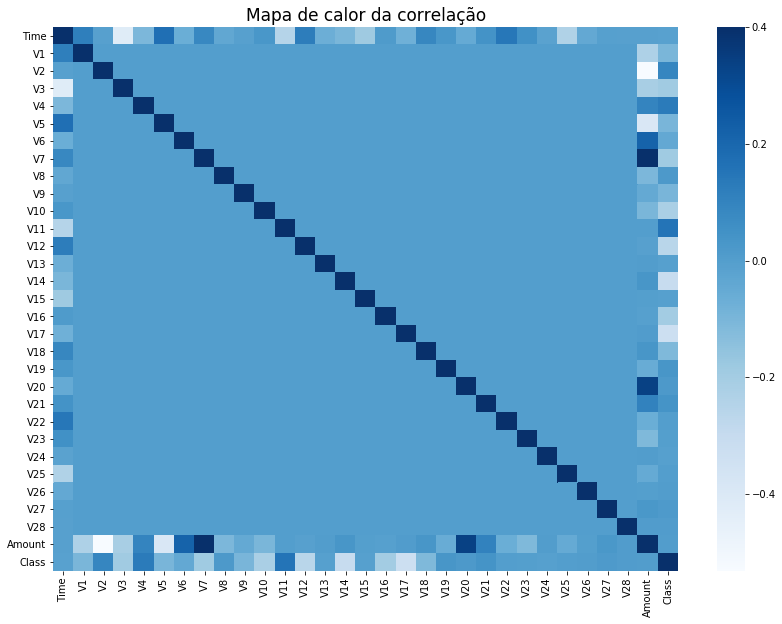

In [6]:
plt.figure(figsize=(14,10))
plt.title('Mapa de calor da correlação', fontsize=17)
sns.heatmap(df.corr(), vmax=0.4, cmap='Blues');

<font size=3>Agora vamos verificar a distribuição de cada variável, quando o nosso target é fraude ou uma transação normal. Com isso podemos verificar que para algumas varáveis possuem uma distribuções diferentes que pode indicar que pode ser relevante para o nosso modelo.</font>

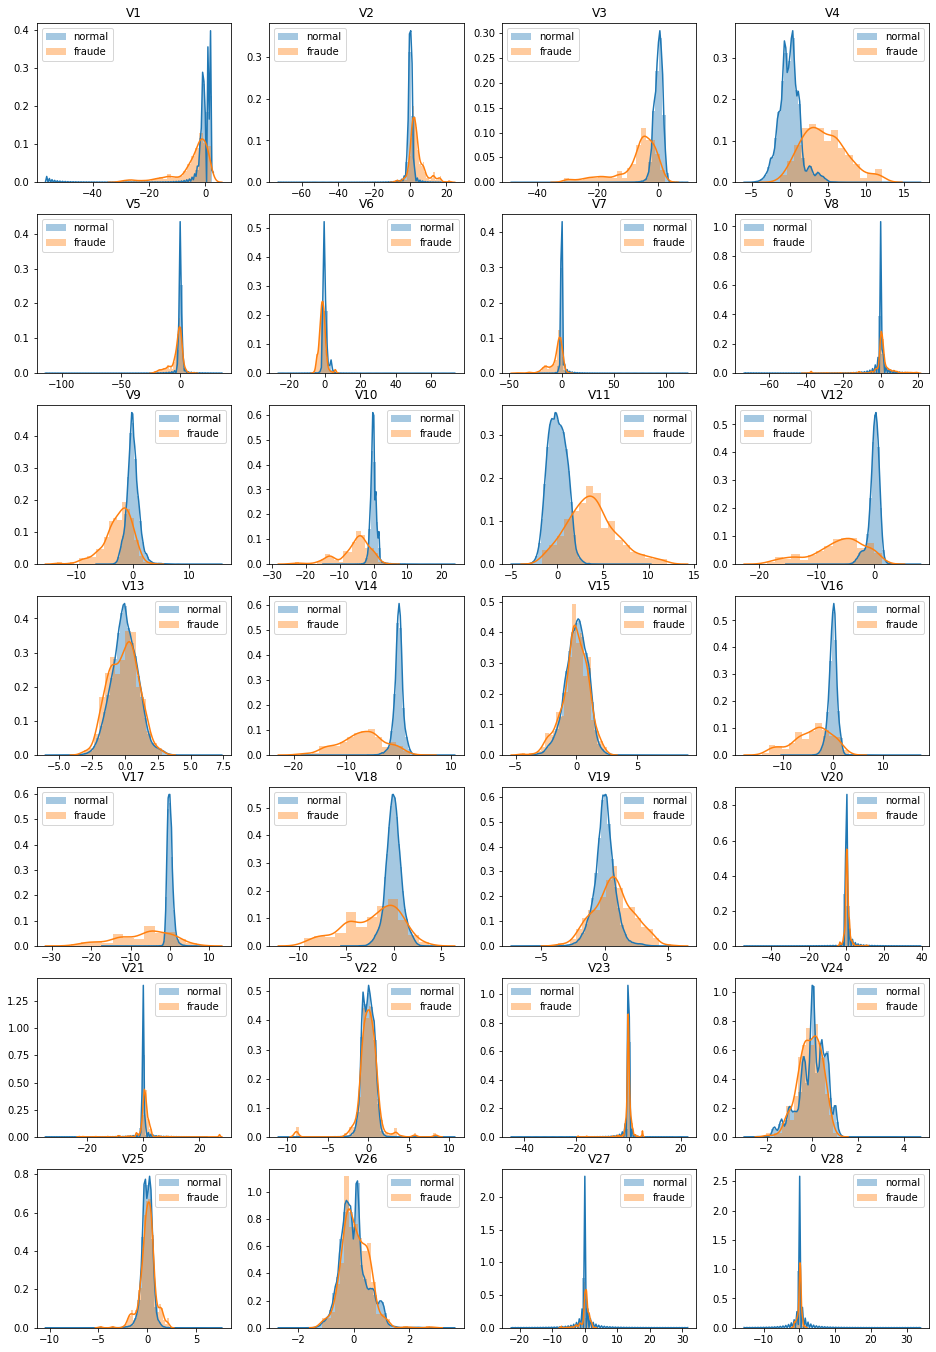

In [7]:
fig, ax = plt.subplots(nrows=7, ncols=4, figsize=(16,24))
v = 1
for j in range(7):
    for i in range(4):
        sns.distplot(df[df['Class']==0]['V{}'.format(v)], ax=ax[j][i], norm_hist=True, label='normal')
        sns.distplot(df[df['Class']==1]['V{}'.format(v)], ax=ax[j][i], norm_hist=True, label='fraude')
        ax[j][i].set_title('V{}'.format(v))
        ax[j][i].set_xlabel('')
        ax[j][i].legend()
        v += 1

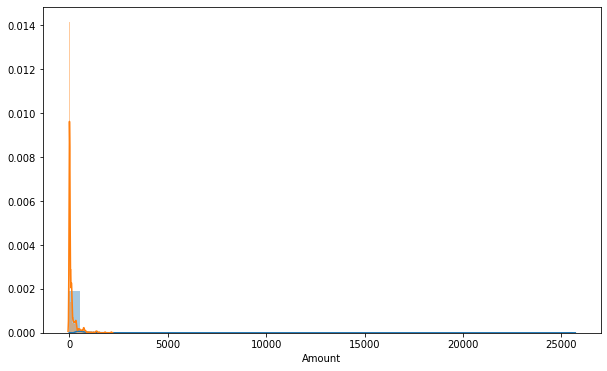

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6))
sns.distplot(df[df['Class']==0]['Amount'], norm_hist=True, ax=ax)
sns.distplot(df[df['Class']==1]['Amount'], norm_hist=True, ax=ax);

<a name='PREPRO'></a>
<h2>Pré-processamento dos dados</h2>
<font size=3>Primeiros vamos separar as variáveis preditoras e preditas.</font>

In [9]:
X = df.drop('Class', axis=1)
Y = df['Class']

<font size=3>Após isso vamos dividir os dados em treino e teste.</font>

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=79)
print('X_train: {}\nX_test:\t {}\ny_train: {}\ny_test:\t {}'.format(X_train.shape, X_test.shape,
                                                                    y_train.shape, y_test.shape))

X_train: (170884, 30)
X_test:	 (113923, 30)
y_train: (170884,)
y_test:	 (113923,)


In [11]:
X_train.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
165537,117495.0,1.968015,-0.671108,-0.194401,0.250409,-0.301290,1.342763,-1.191137,0.445347,1.817423,...,-0.143510,-0.041509,0.281936,0.137295,-0.329392,-0.151821,-0.351931,0.076986,-0.041105,1.00
243501,151954.0,-1.645532,1.310324,-1.092048,-0.264742,0.211897,-1.426228,0.330092,0.372642,-0.062103,...,-0.454930,0.360841,1.481824,0.412538,0.055064,-0.577127,-0.217609,0.135810,0.181622,2.69
39328,39794.0,1.230068,-1.614168,1.247064,-1.269068,-2.166050,0.031046,-1.678157,0.130706,-1.257381,...,-0.130415,0.161652,0.717876,-0.057583,0.094893,0.099069,-0.022422,0.082423,0.051996,110.00
232921,147370.0,-1.070450,0.119314,1.352326,0.174618,1.202196,-1.320857,0.412107,-0.122151,-0.633675,...,0.295339,-0.209148,-0.817785,-0.119271,0.058476,0.379664,0.499730,-0.043053,0.069660,1.29
227868,145260.0,-0.413328,1.301241,1.451162,4.465927,-0.083834,1.362130,-0.438776,0.779888,-1.568128,...,0.133876,0.386092,1.043509,-0.021812,0.609969,-0.695184,0.463574,0.119990,0.134411,30.26


<a name='RF'></a>
<h2>Random Forrest </h2>
<font size=3>O primeiro modelo que vamos testar é <i>Random Forrest</i>, e o as parâmetros que vamos tunar é : <i>n_estimator</i>, <i>max_depth</i> e <i>min_samples_leaf</i>.</font>

In [12]:
rf = RandomForestClassifier(n_estimators=20, max_depth=100, min_samples_leaf=3, random_state=79)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

<font size=3>Tunando os parâmetros chegamos nos seguintes valores das métricas.</font>

In [13]:
precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred)
roc = roc_auc_score(y_test, y_pred)
print('precision:\t{}\nrecall:\t\t{}\nfscore:\t\t{}\nroc auc:\t{}\n'.format(precision[1], recall[1], fscore[1], roc))

precision:	0.9316770186335404
recall:		0.7894736842105263
fscore:		0.8547008547008548
roc auc:	0.894688483229651



<a name='LGBM'></a>
<h2>LightGBM</h2>
<font size=3>Agora é a vez de usarmos LightGBM, neste momento não vamos tunar nenhum parâmetro já que iremos fazer isso futuramente, e este modelo será utilizado como baseline para o modelo tunado.</font>

In [14]:
mdl = LGBMClassifier(random_state=75, class_weight="balanced", n_jobs=6)
mdl.fit(X_train, y_train)
y_pred = mdl.predict(X_test)

<font size=3>Com isso as mesmas métricas que utilizamos para <i>Random Forrest</i> tiveram os seguintes valores.</font>

In [15]:
precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred)
roc = roc_auc_score(y_test, y_pred)
print('precision:\t{}\nrecall:\t\t{}\nfscore:\t\t{}\nroc auc:\t{}\n'.format(precision[1], recall[1], fscore[1], roc))

precision:	0.8764044943820225
recall:		0.8210526315789474
fscore:		0.8478260869565217
roc auc:	0.9104295980382492



<a name='BAYES'></a>
<h2>Bayesian Optimization</h2>
<font size=3>Para tunarmos nosso LightGBM vamos utilizar o método de <i>Otimização Bayesiana</i>, onde colocamos um espaço amostral e o modelo itera tirando um conjunto de hiperparâmetros aleatórios e medindo a função de custo afim de optimizá-la.<br>
Optamos pela precisão, pois como se trata de fraude o ideal é pegar a maior quantidade possível de verdadeiro positivo.</font>

In [16]:
def tune_lgbm(params):
    print(params)
    lr = params[0]
    max_depth = params[1]
    min_child_samples = params[2]
    subsample = params[3]
    colsample_bytree = params[4]
    n_estimators = params[5]
    
    mdl = LGBMClassifier(learning_rate=lr, num_leaves=2 ** max_depth, max_depth=max_depth, 
                         min_child_samples=min_child_samples, subsample=subsample,
                         colsample_bytree=colsample_bytree, bagging_freq=1, n_estimators=n_estimators,
                         random_state=0, class_weight="balanced", n_jobs=6)
    mdl.fit(X_train, y_train)
    
    y_pred = mdl.predict(X_test)
    
    print(roc_auc_score(y_test, y_pred))
    
    precision, _, _, _ = precision_recall_fscore_support(y_test, y_pred)
    
    return -precision[1]


space = [(1e-3, 1e-1, 'log-uniform'), # lr
          (1, 10), # max_depth
          (1, 35), # min_child_samples
          (0.05, 1.), # subsample
          (0.05, 1.), # colsample_bytree
          (100,1500)] # n_estimators

res = forest_minimize(tune_lgbm, space, random_state=79, n_random_starts=20, n_calls=50, verbose=1)

Iteration No: 1 started. Evaluating function at random point.
[0.006292827825947035, 4, 21, 0.8231120604404752, 0.46248056016314054, 565]
0.9391949380983254
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 8.3871
Function value obtained: -0.2024
Current minimum: -0.2024
Iteration No: 2 started. Evaluating function at random point.
[0.0023287966765846344, 3, 16, 0.1261298714290931, 0.998324765488932, 1187]
0.9341691783202302
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 9.4991
Function value obtained: -0.2145
Current minimum: -0.2145
Iteration No: 3 started. Evaluating function at random point.
[0.03860565731159443, 7, 16, 0.30299386785015586, 0.24266837841573718, 951]
0.9025744275489177
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 17.7217
Function value obtained: -0.9217
Current minimum: -0.9217
Iteration No: 4 started. Evaluating function at random point.
[0.01102780596030231, 7, 3, 0.8384254088062836, 0.6808661755213409,

<font size=3>Após 50 iterações chegamos no melhor resultado com o seguinte conjunto de hiperparâmetros.</font>

In [17]:
res.x

[0.06052313704979792, 7, 27, 0.2930898869102177, 0.20020677273627868, 988]

<a name='MODEL'></a>
<h2>Modelo Final</h2>
<font size=3>Com isso chegamos no modelo final com os hiperparâmetros que tunamos.</font>

In [18]:
params = res.x
lr = params[0]
max_depth = params[1]
min_child_samples = params[2]
subsample = params[3]
colsample_bytree = params[4]
n_estimators = params[5]

mdl = LGBMClassifier(learning_rate=lr, num_leaves=2 ** max_depth, max_depth=max_depth, 
                     min_child_samples=min_child_samples, subsample=subsample,
                     colsample_bytree=colsample_bytree, bagging_freq=1, n_estimators=n_estimators,
                     random_state=0, class_weight="balanced", n_jobs=6)
mdl.fit(X_train, y_train)
y_pred = mdl.predict(X_test)

<font size=3>Podemos ver que as métricas que obtivemos foram melhor que os anteriores.</font>

In [19]:
precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred)
roc = roc_auc_score(y_test, y_pred)
print('precision:\t{}\nrecall:\t\t{}\nfscore:\t\t{}\nroc auc:\t{}\n'.format(precision[1], recall[1], fscore[1], roc))

precision:	0.9390243902439024
recall:		0.8105263157894737
fscore:		0.8700564971751412
roc auc:	0.905219195280544



<a href='#IND'><font size=3>Voltar para o índice</font></a>